In [1]:
import tensorflow as tf,os,math,numpy as np
from tensorflow.keras import layers
from tensorflow.keras import callbacks as tkc
from tensorflow.keras.preprocessing.image import load_img,array_to_img,img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from IPython.display import display
import pylab as pl,PIL

def scale01(img): 
    return img/255

def process_input(input_rgb,img_size):
    input_yuv=tf.image.rgb_to_yuv(input_rgb)
    last_dimension_axis=len(input_yuv.shape)-1
    y,u,v=tf.split(input_yuv,3,axis=last_dimension_axis)
    return tf.image.resize(y,[img_size,img_size],method='bicubic')

def process_target(input_rgb):
    input_yuv=tf.image.rgb_to_yuv(input_rgb)
    last_dimension_axis=len(input_yuv.shape)-1
    y,u,v=tf.split(input_yuv,3,axis=last_dimension_axis)
    return y

train_high_ds = '/home/cst2/preprocessed_data/train/resized_ds'
validate_high_ds = '/home/cst2/preprocessed_data/validate/resized_ds'

[crop_size,upscale_factor]=[200,2]
input_size=crop_size//upscale_factor
batch_size=8

train_ds=image_dataset_from_directory(
    train_high_ds,batch_size=batch_size,
    image_size=(crop_size,crop_size),
    validation_split=.2,subset='training',
    seed=123,label_mode=None,)

valid_ds=image_dataset_from_directory(
    validate_high_ds,batch_size=batch_size,
    image_size=(crop_size,crop_size),
    validation_split=.2,subset='validation',
    seed=1234,label_mode=None,)

train_ds=train_ds.map(scale01)
valid_ds=valid_ds.map(scale01)

test_path='/home/cst2/preprocessed_data/test/resized_ds/resized'
test_paths=sorted(
    [os.path.join(test_path,fname) 
    for fname in os.listdir(test_path)
    if fname.endswith('.jpg')])

train_ds=train_ds.map(
    lambda x: (process_input(x,input_size),process_target(x)))
train_ds=train_ds.prefetch(buffer_size=16)

valid_ds=valid_ds.map(
    lambda x: (process_input(x,input_size),process_target(x)))
valid_ds=valid_ds.prefetch(buffer_size=16)

for batch in valid_ds.take(1):
    for img in batch[0]: display(array_to_img(img)); break
    print(10*'==> ')
    for img in batch[1]: display(array_to_img(img)); break
        
def model(upscale_factor=upscale_factor,channels=3):
    conv_args={'activation':'relu',
               'kernel_initializer':'Orthogonal',
               'padding':'same',}
    
    inputs=tf.keras.Input(shape=(None,None,1))
    x = layers.Conv2D(256,5,**conv_args)(inputs)
    x = layers.Conv2D(96,5,**conv_args)(x)
    x = layers.Conv2D(32,3,**conv_args)(x)
    x = layers.Conv2D(channels*(upscale_factor**2),3,**conv_args)(x)
    outputs=tf.nn.depth_to_space(x,upscale_factor)
    
    return tf.keras.Model(inputs,outputs)

def display_results(img,prefix,title):
    img_array=img_to_array(img)
    img_array=img_array.astype('float32')/255
    fig,ax=pl.subplots()
    im=ax.imshow(img_array[::-1],origin='lower')
    pl.title(title)
    pl.show()
    
def low_resolution_img(img,upscale_factor):
    dimensions=(img.size[0]//upscale_factor,
                img.size[1]//upscale_factor)
    return img.resize(dimensions,PIL.Image.BICUBIC,)

def upscale_img(model,img):
    ycbcr=img.convert('YCbCr')
    y,cb,cr=ycbcr.split()
    y=img_to_array(y).astype('float32')/255
    input_img=np.expand_dims(y,axis=0)
    out=model.predict(input_img)
    out_img_y=out[0]*255.
    out_img_y=out_img_y.clip(0,255)
    out_img_y=out_img_y.reshape(
        (np.shape(out_img_y)[0],np.shape(out_img_y)[1]))
    out_img_y=PIL.Image.fromarray(np.uint8(out_img_y),mode='L')
    out_img_cb=cb.resize(out_img_y.size,PIL.Image.BICUBIC)
    out_img_cr=cr.resize(out_img_y.size,PIL.Image.BICUBIC)
    out_img=PIL.Image.merge(
        'YCbCr',(out_img_y,out_img_cb,out_img_cr))
    return out_img.convert('RGB')


class ESPCNCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback,self).__init__()
        
    def on_epoch_begin(self,epoch,logs=None):
        self.psnr=[]
        
    def on_epoch_end(self,epoch,logs=None):
        print('mean PSNR for epoch: %.2f'%(np.mean(self.psnr)))
        
    def on_test_batch_end(self,batch,logs=None):
        self.psnr.append(10*math.log10(1/logs['loss']))

2021-11-29 10:28:39.019576: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
early_stopping=callbacks.EarlyStopping(monitor='loss',verbose=2,patience=10)

checkpoint_path='/home/cst2/Testing Code/checkpoint/espcnn'
checkpoint=callbacks.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    monitor='loss',mode='min',save_best_only=True,verbose=2)

lr_reduction=callbacks.ReduceLROnPlateau(monitor='val_loss',patience=10,verbose=2,factor=.9)

model=model(upscale_factor=upscale_factor,channels=1)

model.summary()

callbacks=[ESPCNCallback(),early_stopping,checkpoint,lr_reduction]

loss_fn=tf.keras.losses.MeanSquaredError()

optimizer=tf.keras.optimizers.Adam(learning_rate=.0001)

In [ ]:
epochs=50

model.compile(optimizer=optimizer,loss=loss_fn,metrics=['accuracy'],)

history=model.fit(train_ds,epochs=epochs,callbacks=callbacks,validation_data=valid_ds,verbose=2)

model.load_weights(checkpoint_path)

Epoch 1/50


2021-11-29 10:29:25.608045: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-11-29 10:29:26.494359: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


800/800 - 18s - loss: 0.0047 - accuracy: 0.0045 - val_loss: 7.2747e-04 - val_accuracy: 0.0042
mean PSNR for epoch: 31.30

Epoch 00001: loss improved from inf to 0.00467, saving model to /home/cst2/Testing Code/checkpoint/espcnn
Epoch 2/50
800/800 - 17s - loss: 6.9931e-04 - accuracy: 0.0045 - val_loss: 6.7755e-04 - val_accuracy: 0.0042
mean PSNR for epoch: 31.56

Epoch 00002: loss improved from 0.00467 to 0.00070, saving model to /home/cst2/Testing Code/checkpoint/espcnn
Epoch 3/50
800/800 - 17s - loss: 6.5959e-04 - accuracy: 0.0045 - val_loss: 6.4915e-04 - val_accuracy: 0.0042
mean PSNR for epoch: 31.74

Epoch 00003: loss improved from 0.00070 to 0.00066, saving model to /home/cst2/Testing Code/checkpoint/espcnn
Epoch 4/50
800/800 - 17s - loss: 6.4797e-04 - accuracy: 0.0045 - val_loss: 6.3480e-04 - val_accuracy: 0.0042
mean PSNR for epoch: 31.92

Epoch 00004: loss improved from 0.00066 to 0.00065, saving model to /home/cst2/Testing Code/checkpoint/espcnn
Epoch 5/50
800/800 - 17s - loss

PSNR of low resolution and high resolution is 31.1799
PSNR of predict and high resolution is 31.4879


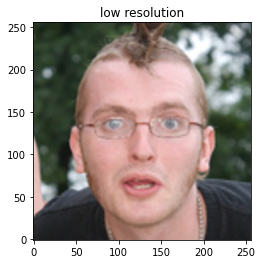

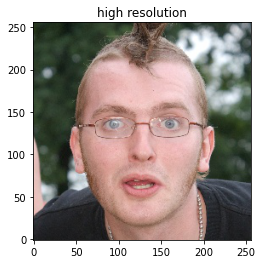

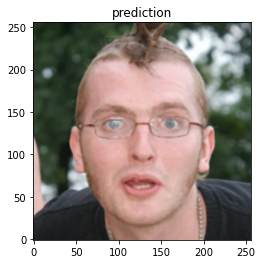

PSNR of low resolution and high resolution is 32.8316
PSNR of predict and high resolution is 32.7507


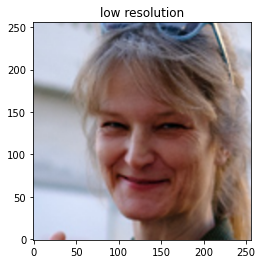

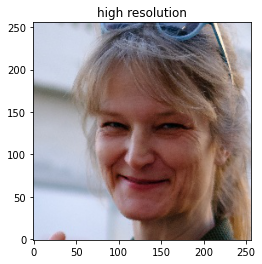

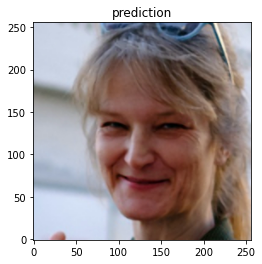

PSNR of low resolution and high resolution is 33.4500
PSNR of predict and high resolution is 33.0595


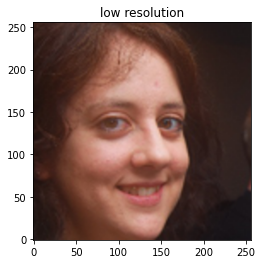

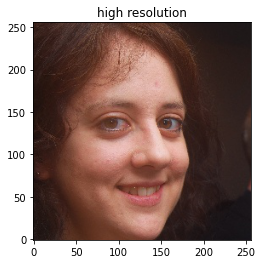

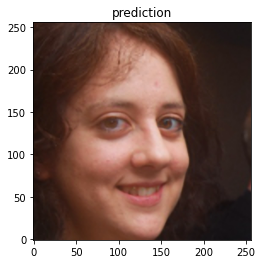

PSNR of low resolution and high resolution is 28.3846
PSNR of predict and high resolution is 28.8229


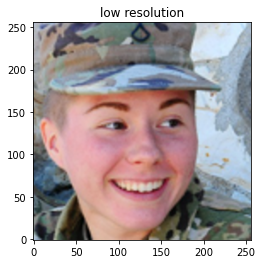

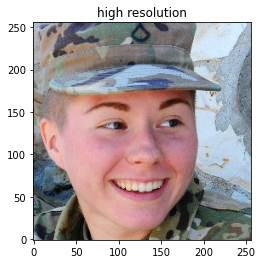

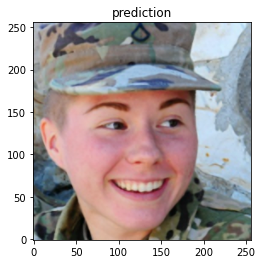

PSNR of low resolution and high resolution is 25.0418
PSNR of predict and high resolution is 25.3845


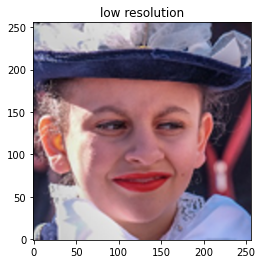

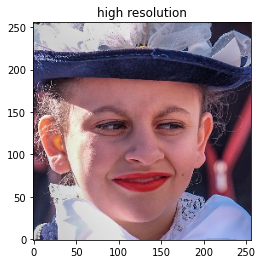

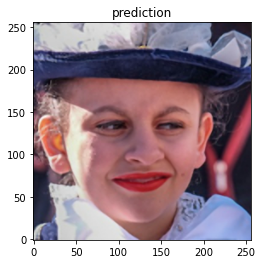

PSNR of low resolution and high resolution is 29.5121
PSNR of predict and high resolution is 30.3680


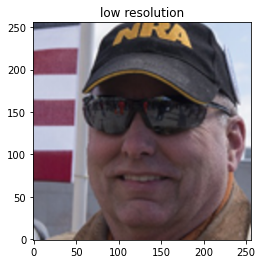

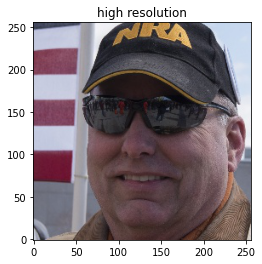

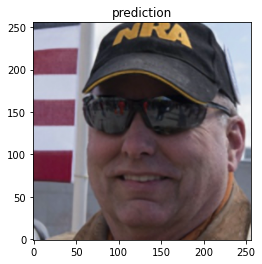

PSNR of low resolution and high resolution is 31.8701
PSNR of predict and high resolution is 31.8306


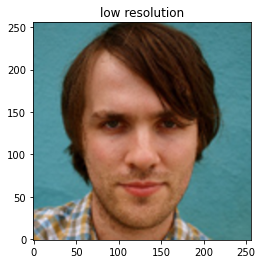

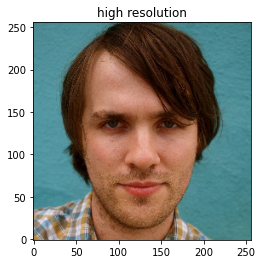

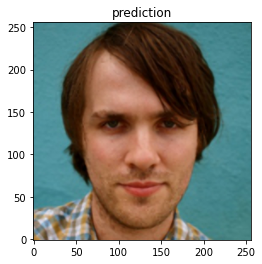

PSNR of low resolution and high resolution is 28.5984
PSNR of predict and high resolution is 28.7344


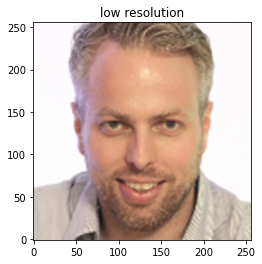

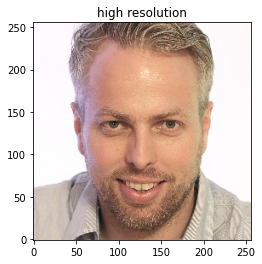

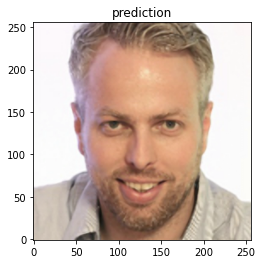

PSNR of low resolution and high resolution is 32.0471
PSNR of predict and high resolution is 32.0038


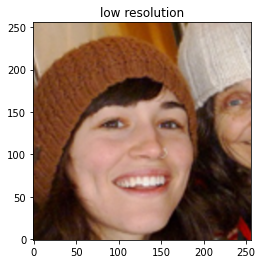

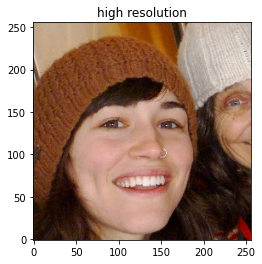

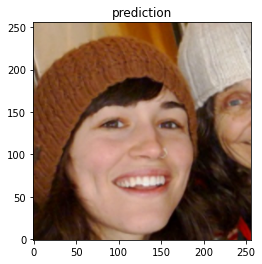

PSNR of low resolution and high resolution is 28.1478
PSNR of predict and high resolution is 28.5538


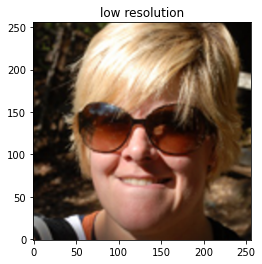

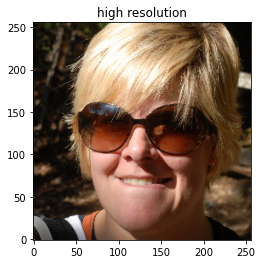

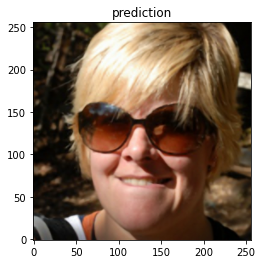

avg. PSNR of images with low resolution is 30.1063
avg. PSNR of reconstructions is 30.2996


In [17]:
total_bicubic_psnr=0.
total_test_psnr=0.
n_img=10

for index,test_path in enumerate(test_paths[0:n_img]):
    
    img=load_img(test_path)
    lowres_input=low_resolution_img(img,upscale_factor)
    
    w=lowres_input.size[0]*upscale_factor
    h=lowres_input.size[1]*upscale_factor
    
    highres_img=img.resize((w,h))
    
    predict_img=upscale_img(model,lowres_input)
    
    lowres_img=lowres_input.resize((w,h))
    lowres_img_arr=img_to_array(lowres_img)
    
    highres_img_arr=img_to_array(highres_img)
    
    predict_img_arr=img_to_array(predict_img)
    
    bicubic_psnr=tf.image.psnr(lowres_img_arr,highres_img_arr,max_val=255)
    test_psnr=tf.image.psnr(predict_img_arr,highres_img_arr,max_val=255)
    
    total_bicubic_psnr+=bicubic_psnr
    total_test_psnr+=test_psnr
    
    print('PSNR of low resolution and high resolution is %.4f' %bicubic_psnr)
    
    print('PSNR of predict and high resolution is %.4f' %test_psnr)
    
    display_results(lowres_img,index,'low resolution')
    display_results(highres_img,index,'high resolution')
    display_results(predict_img,index,'prediction')
    
print('avg. PSNR of images with low resolution is %.4f' %(total_bicubic_psnr/n_img))

print('avg. PSNR of reconstructions is %.4f' %(total_test_psnr/n_img))